### EDA - EXPLORATORY DATA ANALYSIS

We are going to perform an initial analysis of the dataset. This will help us familiarize ourselves with the data, its features and the relationships we want our model to address.

We are going to use the `stock.py` class and `loader.py` to load the data and perform the analysis. These are classes and methods that we used earlier in the project. We will show their usage here.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from stock import Stock

We can choose any valid ticker symbol and the class will download the data from Yahoo Finance using the `yfinance` library.

In [4]:
ticker = 'ACHR'
my_stock = Stock(ticker)
my_stock.load_data()

Ticker: ACHR has 1 anomalies:
  Open-pClose Anomalies: 1


We show here how what information are stored in the `Stock` class.

In [7]:
print(my_stock.ticker)
print(my_stock.first_date)
print(my_stock.last_date)
print(my_stock.df.head())
print(my_stock.df.tail())


ACHR
2020-12-18 00:00:00-05:00
2025-02-20 00:00:00-05:00
                            Open   High   Low  Close  Volume  Dividends  \
Date                                                                      
2020-12-18 00:00:00-05:00  10.15  10.15  9.96   9.97   54500        0.0   
2020-12-21 00:00:00-05:00  10.34  10.34  9.83  10.07   23700        0.0   
2020-12-22 00:00:00-05:00  10.09  10.12  9.96  10.02  186000        0.0   
2020-12-23 00:00:00-05:00  10.14  10.23  9.73  10.06   30500        0.0   
2020-12-24 00:00:00-05:00  10.05  10.19  9.95  10.03  254300        0.0   

                           Stock Splits   Returns  Log_Returns  
Date                                                            
2020-12-18 00:00:00-05:00           0.0       NaN          NaN  
2020-12-21 00:00:00-05:00           0.0  0.010030     0.009980  
2020-12-22 00:00:00-05:00           0.0 -0.004965    -0.004978  
2020-12-23 00:00:00-05:00           0.0  0.003992     0.003984  
2020-12-24 00:00:00-05:00  

In [9]:
for key, value in my_stock.info.items():
    print(f"{key}: {value}")

{'address1': '190 West Tasman Drive', 'city': 'San Jose', 'state': 'CA', 'zip': '95134', 'country': 'United States', 'phone': '650 272 3233', 'website': 'https://www.archer.com', 'industry': 'Aerospace & Defense', 'industryKey': 'aerospace-defense', 'industryDisp': 'Aerospace & Defense', 'sector': 'Industrials', 'sectorKey': 'industrials', 'sectorDisp': 'Industrials', 'longBusinessSummary': 'Archer Aviation Inc., together with its subsidiaries, engages in designs, develops, and operates electric vertical takeoff and landing aircraft for use in urban air mobility. The company was formerly known as Atlas Crest Investment Corp. and changed its name to Archer Aviation Inc. The company is headquartered in San Jose, California.', 'fullTimeEmployees': 578, 'companyOfficers': [{'maxAge': 1, 'name': 'Mr. Adam D. Goldstein', 'age': 45, 'title': 'Founder, CEO & Director', 'yearBorn': 1979, 'fiscalYear': 2023, 'totalPay': 1003750, 'exercisedValue': 0, 'unexercisedValue': 0}, {'maxAge': 1, 'name': 

In [10]:
fig = my_stock.plot_close(log_scale=True)
if fig:
    fig.show()

### DATA ANALYSIS

Now, let's dive into the analysis of the data we chose.

In [12]:
from scipy import stats
from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

As first thing, we want to check the statistical properties of the time series we have.

In [ ]:
stock_returns = my_stock.df['Log_Returns'].dropna()

# Comprehensive statistics in one statement
print(f"{my_stock.ticker} Log Returns Analysis, period: {my_stock.first_date.strftime('%Y.%m.%d')} - {my_stock.last_date.strftime('%Y.%m.%d')}")
print("-" * 75)
print(f"Mean:     {stock_returns.mean():.6f}")
print(f"Median:   {stock_returns.median():.6f}")
print(f"Std Dev:  {stock_returns.std():.6f}")
print(f"Skewness: {stock_returns.skew():.6f}")
print(f"Kurtosis: {stock_returns.kurtosis():.6f}")  # Excess kurtosis
print("")
print("A skewness value deviating from zero suggests the distribution is either left-skewed (positive skewness) or right-skewed (negative skewness).")
print("Excess kurtosis significantly greater than 0 indicates the presence of heavy tails in the distribution.")

# Normality test (Jarque-Bera)
stat, p_value = stats.jarque_bera(stock_returns.dropna())
print(f"\nJarque-Bera test for normality:")
print(f"p-value: {p_value:.6f}")
print("(p-value close to 0 indicates non-normality)")

# Stationarity test (Augmented Dickey-Fuller)
adf_result = adfuller(stock_returns.dropna())
print(f"\nADF test for stationarity:")
print(f"p-value: {adf_result[1]:.6f}")
print("(p-value close to 0 indicates stationarity)")

# Autocorrelation test (Ljung-Box with lags 5, 10, 15, 20)
lb_result = acorr_ljungbox(stock_returns.dropna(), lags=[5, 10, 15, 20])
print(f"\nLjung-Box test for autocorrelation (lags 5, 10, 15, 20):")  # Tests for autocorrelation in the series
print(f"p-values: {lb_result['lb_pvalue'].values[0]:.6f} (lag 5), {lb_result['lb_pvalue'].values[1]:.6f} (lag 10), \
{lb_result['lb_pvalue'].values[2]:.6f} (lag 15), {lb_result['lb_pvalue'].values[3]:.6f} (lag 20)")
print("(p-value close to 0 indicates presence of autocorrelation)")

ACHR Log Returns Analysis, period: 2020.12.18 - 2025.02.20
---------------------------------------------------------------------------
Mean:     0.000015
Median:   -0.001009
Std Dev:  0.051145
Skewness: 0.722650
Kurtosis: 4.185435

Deviation of skewness from zero indicates left-skewed (positive) or right skewed (negative).
The value of excess kurtosis, if significantly greater than 0, indicates heavy tails.

Jarque-Bera test for normality:
p-value: 0.000000
(p-value close to 0 indicates non-normality)

ADF test for stationarity:
p-value: 0.000000
(p-value close to 0 indicates stationarity)

Ljung-Box test for autocorrelation (lags 5, 10, 15, 20):
p-values: 0.037736 (lag 5), 0.040093 (lag 10), 0.021091 (lag 15), 0.000347 (lag 20)
(p-value close to 0 indicates presence of autocorrelation)


The next step is to clearly visualize the distribution of the returns.

Outliers removed: 1


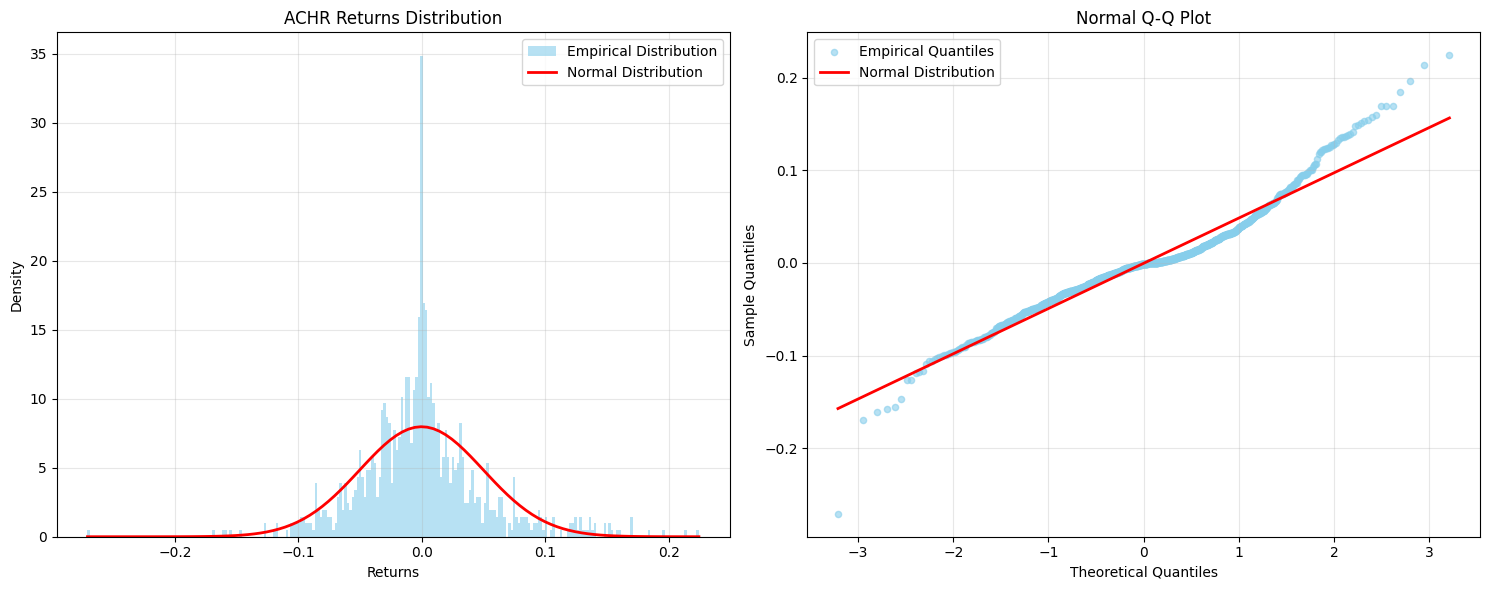

In [19]:
def remove_outliers(data, k=2):
    """
    Helper function to remove outliers using IQR method
    k: multiplier for IQR (default=2 for moderate outlier removal)
    :return: filtered data
    """
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    return data[(data >= Q1 - k * IQR) & (data <= Q3 + k * IQR)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Get both full and filtered data. Tune the multiplier k to remove outliers for better visualization.
full_returns = stock_returns.dropna()
filtered_returns = remove_outliers(full_returns, k=6)

# Decide which data to use (whether the filtered or the full data)
returns = filtered_returns
if len(returns) < len(full_returns):
    print(f"Outliers removed: {len(full_returns) - len(returns)}")

# Left plot: Returns Distribution
# Calculate histogram data
hist, bins, _ = ax1.hist(returns.dropna(), bins=250, density=True, 
                        alpha=0.6, color='skyblue', label='Empirical Distribution')

# Add normal distribution curve
x_range = np.linspace(returns.min(), returns.max(), 100)
normal_dist = stats.norm.pdf(x_range, returns.mean(), returns.std())
ax1.plot(x_range, normal_dist, 'r-', lw=2, label='Normal Distribution')

ax1.set_title(f'{my_stock.ticker} Returns Distribution')
ax1.set_xlabel('Returns')
ax1.set_ylabel('Density')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right plot: Q-Q Plot
# Calculate Q-Q plot data
theoretical_quantiles, sample_quantiles = stats.probplot(returns.dropna(), dist="norm")[0]
slope, intercept = np.polyfit(theoretical_quantiles, sample_quantiles, 1)

# Plot empirical points
ax2.scatter(theoretical_quantiles, sample_quantiles, 
           color='skyblue', alpha=0.6, s=20, label='Empirical Quantiles')

# Plot the reference line
ax2.plot(theoretical_quantiles, slope * theoretical_quantiles + intercept, 
         'r-', lw=2, label='Normal Distribution')

ax2.set_title('Normal Q-Q Plot')
ax2.set_xlabel('Theoretical Quantiles')
ax2.set_ylabel('Sample Quantiles')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### AUTOCORRELATION ANALYSIS

We will now focus on the analysis of the autocorrelation of our time series. As you may know, financial returns often exhibit autocorrelation both in the levels but also in their squares. The first level of correlation is simple to interpret: past return may affect the next returns. The second kind of autocorrelation is more subtle and many times also more persistent: the volatility (approximated by the squared returns) can have strong persistence, which means that shocks in the returns can have a long lasting effect not only on the next return but also on the volatility of the returns. This effect is often long lasting, meaning it has a long effect in the future returns.

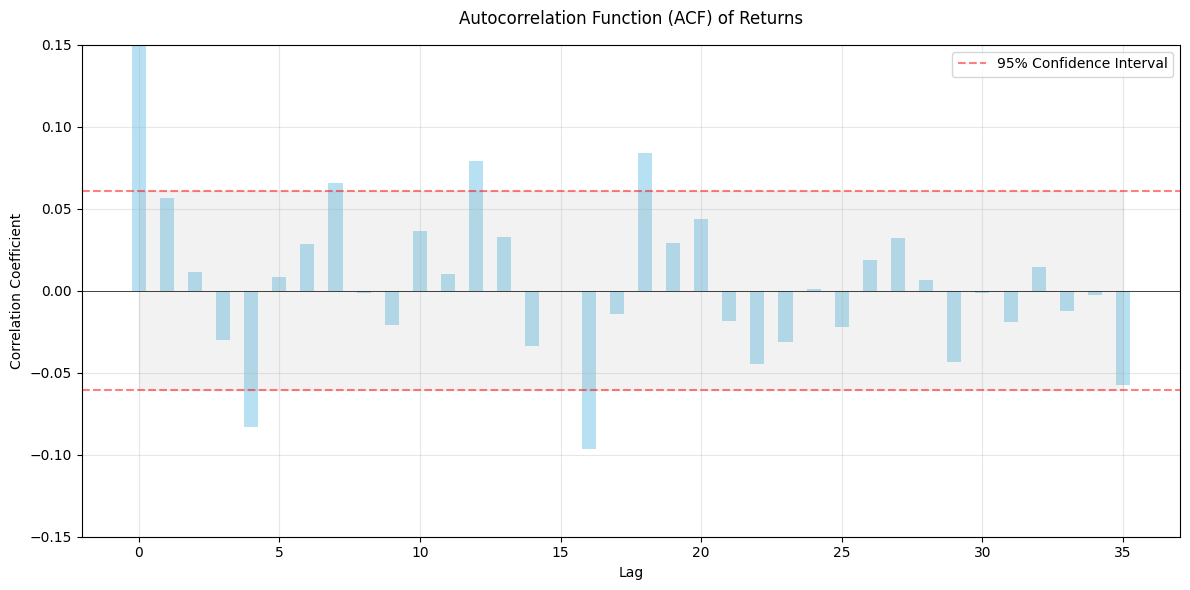


Autocorrelation Function (ACF) Values:
--------------------------------------------------
Lag        ACF Value
--------------------------------------------------
0             1.0000
1             0.0566
2             0.0116
3            -0.0299
4            -0.0832
5             0.0085
6             0.0284
7             0.0655
8            -0.0012
9            -0.0207
10            0.0362
11            0.0101
12            0.0791
13            0.0328
14           -0.0334
15           -0.0003
16           -0.0965
17           -0.0142
18            0.0838
19            0.0289
20            0.0438
21           -0.0183
22           -0.0447
23           -0.0313
24            0.0010
25           -0.0224
26            0.0187
27            0.0325
28            0.0066
29           -0.0435
30           -0.0016
31           -0.0193
32            0.0142
33           -0.0121
34           -0.0024
35           -0.0575


In [22]:
plt.figure(figsize=(12, 6))

# Calculate ACF values (excluding lag 0)
acf_values = acf(full_returns, nlags=35, fft=True)  # Skip lag 0
lags = np.arange(0, len(acf_values))

# Calculate confidence intervals
# Using 1.96/sqrt(n) for 95% confidence level
n = len(full_returns)
conf_level = 1.96 / np.sqrt(n)

# Create the plot
plt.bar(lags, acf_values, width=0.5, color='skyblue', alpha=0.6)

# Add confidence interval bands
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.axhline(y=conf_level, color='red', linestyle='--', alpha=0.5, 
           label='95% Confidence Interval')
plt.axhline(y=-conf_level, color='red', linestyle='--', alpha=0.5)

# Add shaded confidence interval area
plt.fill_between(lags, -conf_level, conf_level, color='gray', alpha=0.1)

plt.title('Autocorrelation Function (ACF) of Returns', pad=15)
plt.xlabel('Lag')
plt.ylabel('Correlation Coefficient')

# Set y-axis limits
# Use max of: 0.2 or the maximum absolute ACF value (excluding lag 0)
max_acf = max(0.15, max(abs(acf_values[1:])) * 1.2)
plt.ylim(-max_acf, max_acf)

plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


# Print ACF values in a formatted table
print("\nAutocorrelation Function (ACF) Values:")
print("-" * 50)
print(f"{'Lag':<8}{'ACF Value':>12}")
print("-" * 50)
for i, value in enumerate(acf_values):
    print(f"{i:<8}{value:>12.4f}")

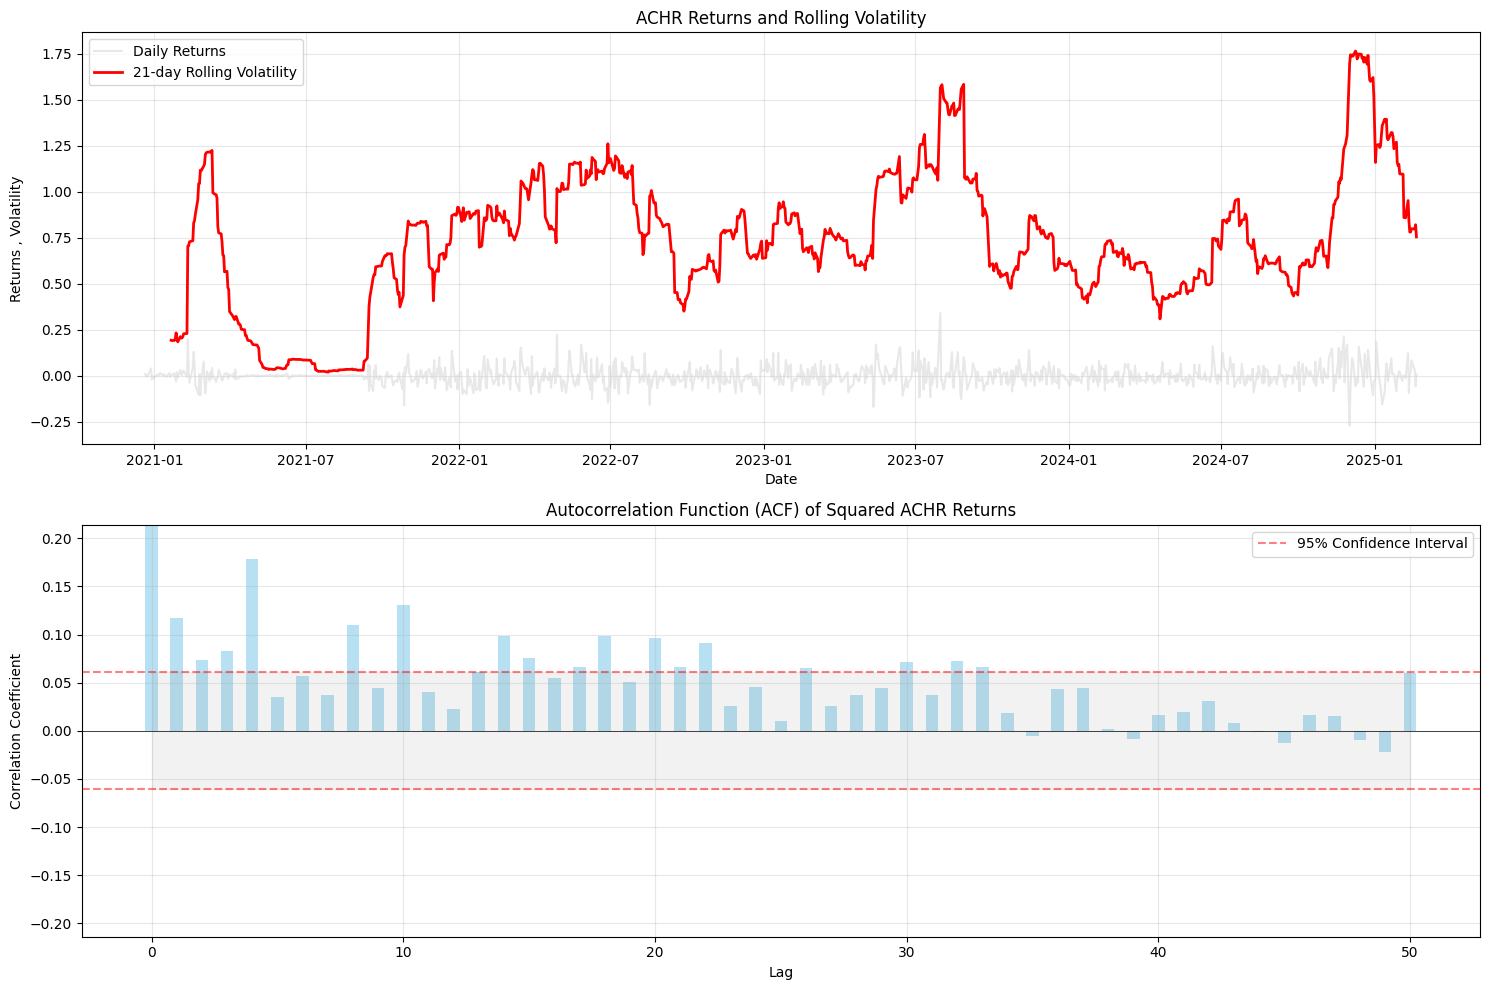

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: Returns and Rolling Volatility
window = 21  # approximately one trading month
rolling_vol = full_returns.rolling(window=window).std() * np.sqrt(252)  # annualized

ax1.plot(full_returns.index, full_returns, color='lightgray', alpha=0.5, label='Daily Returns')
ax1.plot(rolling_vol.index, rolling_vol, color='red', linewidth=2, label=f'{window}-day Rolling Volatility')
ax1.set_title(f'{my_stock.ticker} Returns and Rolling Volatility')
ax1.set_xlabel('Date')
ax1.set_ylabel('Returns , Volatility')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Custom ACF of Squared Returns
squared_returns = full_returns.dropna()**2
acf_values = acf(squared_returns, nlags=50, fft=True)
lags = np.arange(0, len(acf_values))

# Calculate confidence intervals
n = len(squared_returns)
conf_level = 1.96 / np.sqrt(n)

# Create the bar plot
ax2.bar(lags, acf_values, width=0.5, color='skyblue', alpha=0.6)

# Add confidence interval bands
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax2.axhline(y=conf_level, color='red', linestyle='--', alpha=0.5, 
            label='95% Confidence Interval')
ax2.axhline(y=-conf_level, color='red', linestyle='--', alpha=0.5)

# Add shaded confidence interval area
ax2.fill_between(lags, -conf_level, conf_level, color='gray', alpha=0.1)

# Set titles and labels
ax2.set_title(f'Autocorrelation Function (ACF) of Squared {my_stock.ticker} Returns')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Correlation Coefficient')

# Set y-axis limits
max_acf = max(0.15, max(abs(acf_values[1:])) * 1.2)
ax2.set_ylim(-max_acf, max_acf)

ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()